In [19]:
import pandas as pd
import string, math, time, collections, pprint
import numpy as np
import seaborn as sn

from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support
from matplotlib.pyplot import plot as plt

In [2]:
##set directory

import os
path = "/Users/krittikakrishnan/Desktop/Insight Project"
os.chdir(path) #To change path to current directory

In [3]:
rated = pd.read_csv("Rated Sentences.csv")
rated.head(10)

,ID,RATING,SENTENCE
0,6lfb78,-1,i can't stop overthinking things and i have fe...
1,64lplf,1,"i'm taking primrose oil, drinking spearmint te..."
2,8dcp7v,0,my boyfriend and i had had sex on day 9 of the...
3,851v5y,0,"basically, i started taking aviane combination..."
4,7fu6v3,0,today was the last day of my active pills.
5,5yf68k,-1,if i don't get my periods regularly on the pil...
6,8axz89,1,so far i've really been preferring it over the...
7,6vsrj6,0,i started my placebo pills on monday and i wou...
8,6zzyc5,1,"i like my current combo pill, i have been taki..."
9,77fyfg,-1,i just went off the pill in july after having ...


In [4]:
#Standardizing the original title and selftext
def standardize_text(new, text_field):
    new[text_field] = new[text_field].str.replace(r"http\S+", "")
    new[text_field] = new[text_field].str.replace(r"http", "")
    new[text_field] = new[text_field].str.replace(r"@\S+", "")
    new[text_field] = new[text_field].str.replace(r"\n", "")
    new[text_field] = new[text_field].str.replace(r"[^A-Za-z0-9(),.!?@\'\`\"\_\n]", " ")
#     new[text_field] = new[text_field].str.replace(r"@", "at")
    new[text_field] = new[text_field].str.lower()
    return new

# new = standardize_text(uncleaned, "title")
rated = standardize_text(rated, "SENTENCE")

In [5]:
#SENTIMENT ANALYSIS ON SENTENCES --

sia = SIA()
results_body = []
for entry in rated["SENTENCE"]:
    body_score = sia.polarity_scores(entry)
    body_score['SENTENCE'] = entry
    results_body.append(body_score)
results = pd.DataFrame(results_body)

In [6]:
both = pd.merge(results, rated, on = "SENTENCE")

In [143]:
both['label_new'] = 0
both.loc[both['compound'] > 0, 'label_new'] = 0
both.loc[both['compound'] < 0, 'label_new'] = -1
# both.loc[-0.2 < both['compound'] > 0.2, 'label'] = 0

In [144]:
both['rating_new'] = 0
both.loc[both['RATING'] > 0, 'rating_new'] = 0
both.loc[both['RATING'] < 0, 'rating_new'] = -1

In [145]:
both.head(10)

,SENTENCE,compound,neg,neu,pos,ID,RATING,label,label_new,rating_new,label.5,label_0.1
0,i can't stop overthinking things and i have fe...,-0.2512,0.097,0.839,0.063,6lfb78,-1,-1,-1,-1,-1,-1.0
1,"i'm taking primrose oil, drinking spearmint te...",0.7579,0.053,0.742,0.204,64lplf,1,1,0,0,1,0.0
2,my boyfriend and i had had sex on day 9 of the...,0.8807,0.052,0.725,0.223,8dcp7v,0,1,0,0,1,0.0
3,"basically, i started taking aviane combination...",0.0000,0.000,1.000,0.000,851v5y,0,0,0,0,0,-1.0
4,today was the last day of my active pills.,0.4019,0.000,0.748,0.252,7fu6v3,0,1,0,0,1,0.0
5,if i don't get my periods regularly on the pil...,0.0000,0.000,1.000,0.000,5yf68k,-1,0,0,-1,0,-1.0
6,so far i've really been preferring it over the...,0.0000,0.000,1.000,0.000,8axz89,1,0,0,0,0,-1.0
7,i started my placebo pills on monday and i wou...,-0.2960,0.078,0.922,0.000,6vsrj6,0,-1,-1,0,-1,-1.0
8,"i like my current combo pill, i have been taki...",0.3612,0.000,0.828,0.172,6zzyc5,1,1,0,0,1,0.0
9,i just went off the pill in july after having ...,-0.6956,0.137,0.863,0.000,77fyfg,-1,-1,-1,-1,-1,-1.0


In [22]:
subset = (both.RATING == -1) & (both.label == 1)

In [25]:
both[subset].head(10).SENTENCE.values

array(["i can't really afford the financial hit of trying two different iuds within a year, unless i find out tomorrow that medicaid is covering a significant amount of the cost.",
       "please tell me i am overreacting, that it isn't as bad as i have been hearing.",
       "i check the strings myself and don't feel anything abnormal but i feel like i heard two different things from him.",
       "some background i've posted a few times about not being able to successfully skip my period on generic yasmin 28. last month, i bled during my active pills after trying to skip and i had brown discharge for the whole month.",
       'during my last cycle of pills, i got my period early (in week 3 of active pills) and it lasted 8 days (abnormal).',
       'from the full article "another investigation from tokokuni and sagripanti (1994) stated that copper materials implanted in the human body, particularly iuds, corrode with time and release potentially toxic ions, which can increase the prod

In [146]:
##Using scikit learn to create CM
y_true_new = both["rating_new"]
y_pred_new = both["label_new"]
c_mat = cm(y_true_new, y_pred_new)
c_mat

array([[ 54,  43],
       [ 34, 127]])

In [147]:
print(both.groupby("rating_new")["rating_new"].count())

rating_new
-1     97
 0    161
Name: rating_new, dtype: int64


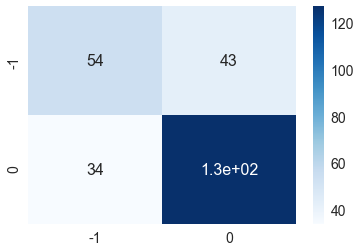

In [148]:
###Attempting to plot confusion matrix

df_cm = pd.DataFrame(c_mat, index = ["-1", "0"], columns = ["-1", "0"])
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap = "Blues", annot=True, annot_kws={"size": 16})# font size

In [149]:
##Checking accuracy of the confusion matrix
accuracy = accuracy_score(y_true_new, y_pred_new, normalize=True, sample_weight=None)
print(accuracy)

0.7015503875968992


In [150]:
##Using scikit learn to create CM
y_true_new = both["rating_new"]
y_pred_new1 = both["label_0.1"]
c_mat1 = cm(y_true_new, y_pred_new1)
c_mat1

array([[ 76,  21],
       [108,  53]])

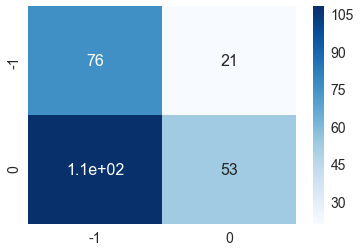

In [151]:
###Attempting to plot other confusion matrix

df1_cm = pd.DataFrame(c_mat1, index = ["-1", "0"], columns = ["-1", "0"])
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df1_cm, cmap = "Blues", annot=True, annot_kws={"size": 16})# font size

In [152]:
print(both.groupby("rating_new")["rating_new"].count())

rating_new
-1     97
 0    161
Name: rating_new, dtype: int64


In [139]:
##Checking accuracy of the confusion matrix
accuracy = accuracy_score(y_true_new, y_pred_new1, normalize=True, sample_weight=None)
print(accuracy)

0.5


In [93]:
##Checking recall of the confusion matrix
recall = recall_score(y_true, y_pred, average = 'macro', sample_weight = None)
print(recall)

0.5511942114362554


Find a way to compute precision and recall for ONLY -1 class!

In [60]:
both['label.5'] = 0
both.loc[both['compound'] > 0.1, 'label.5'] = 1
both.loc[both['compound'] < -0.1, 'label.5'] = -1
# both.loc[-0.2 < both['compound'] > 0.2, 'label'] = 0

In [ ]:
both.head(25)

0.5658914728682171
0.5960572063877098


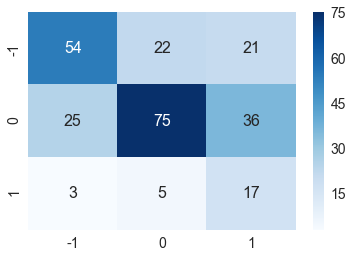

In [62]:
##Using scikit learn to create CM
y_rating = both["RATING"]
y_pred2 = both["label.5"]
cm2 = cm(y_rating, y_pred2)
cm2

###Attempting to plot confusion matrix

df_cm2 = pd.DataFrame(cm2, index = ["-1", "0", "1"], columns = ["-1", "0", "1"])
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm2, cmap = "Blues", annot=True,annot_kws={"size": 16})# font size

##Checking accuracy of the confusion matrix
accuracy2 = accuracy_score(y_rating, y_pred2, normalize=True, sample_weight=None)
print(accuracy2)

##Checking recall of the confusion matrix
recall2 = recall_score(y_rating, y_pred2, average = 'macro', sample_weight = None)
print(recall2)

The above model has worse accuracy but better recall than before!

In [ ]:
###Attempting to see if VADER will do better with <0>

both['label.0'] = 0
both.loc[both['compound'] > 0, 'label.0'] = 1
both.loc[both['compound'] < 0, 'label.0'] = -1
# both.loc[-0.2 < both['compound'] > 0.2, 'label'] = 0

In [ ]:
##Using scikit learn to create CM with label.0
y_true = both["RATING"]
y_pred3 = both["label.0"]
cm3 = confusion_matrix(y_true, y_pred3)
cm3

###Attempting to plot confusion matrix

df_cm3 = pd.DataFrame(cm3, index = ["-1", "0", "1"], columns = ["-1", "0", "1"])
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm3, cmap = "Blues", annot=True,annot_kws={"size": 16})# font size

##Checking accuracy of the confusion matrix
accuracy3 = accuracy_score(y_true, y_pred3, normalize=True, sample_weight=None)
print(accuracy3)

##Checking recall of the confusion matrix
recall3 = recall_score(y_true, y_pred3, average = 'macro', sample_weight = None)
print(recall3)

This does worse than before on both accuracy and recall. Womp womp.